In [1]:
 #accessing netcdf files from Hector's folders
import os, glob, sys
sys.path.append("//nobackup//amondal//Python//Hector_Python_Scripts")
sys.path.append("//nobackup/amondal//Python//mit_geos_analysis")
#from mds_store import openmdsdataset
#playing with netcdf - xarray
import numpy as np
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
# How about visualization?
%matplotlib inline
import netCDF4
from netCDF4 import Dataset
#from xmitgcm import open_mdsdataset
from GetNCDataSet import *
from MITllc2160Depth import *



import xgcm
from spectral_analysis_code import *


from dask.distributed import Client
client = Client(memory_limit='100GB',n_workers = 40, threads_per_worker=1)

/home6/amondal/.conda/envs/xmitgcm3/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39158 instead
  warnings.warn(


So for calculating (gradient) Richardson number, you need a few things.
1. Definitely U, V, T, S (U,V for shear, T, S, for density). 
2. Take appropriate derivatives

In [ ]:
import numpy as np
import gsw
import dens # hector can give you this module if you need it
import glob
import scipy.io as io


## load some grid parameters
YC = np.memmap(prnt+'YC_'+str(NX)+'x'+str(NY), dtype = '>f4',shape=(NY,NX), mode='r').astype(float)[1177:-2,1199:2001]
DYF = np.memmap(prnt+'DYF_'+str(NX)+'x'+str(NY), dtype = '>f4',shape=(NY,NX), mode='r').astype(float)[1177:-2,1199:2001]
DXF = np.memmap(prnt+'DXF_'+str(NX)+'x'+str(NY), dtype = '>f4',shape=(NY,NX), mode='r').astype(float)[1177:-2,1199:2001]
RAU = np.memmap(prnt+'RAW_'+str(NX)+'x'+str(NY), dtype = '>f4',shape=(NY,NX), mode='r').astype(float)[1177:-2,1199:2001]
RAV = np.memmap(prnt+'RAS_'+str(NX)+'x'+str(NY), dtype = '>f4',shape=(NY,NX), mode='r').astype(float)[1177:-2,1199:2001]


## get the file list, I am assuming you have already extracted similar files for your study area
Wf = sorted(glob.glob(prnt+'W_'+str(NX)+'x'+str(NY)+'x'+str(NZ)+'.'+suf+'*'))
Tf = sorted(glob.glob(prnt+'Theta_'+str(NX)+'x'+str(NY)+'x'+str(NZ)+'.'+suf+'*'))
Sf = sorted(glob.glob(prnt+'Salt_'+str(NX)+'x'+str(NY)+'x'+str(NZ)+'.'+suf+'*'))
Uf = sorted(glob.glob(prnt+'U_'+str(NX)+'x'+str(NY)+'x'+str(NZ)+'.'+suf+'*'))
Vf = sorted(glob.glob(prnt+'V_'+str(NX)+'x'+str(NY)+'x'+str(NZ)+'.'+suf+'*'))
Ef = sorted(glob.glob(prnt+'Eta_'+str(NX)+'x'+str(NY)+'.'+suf+'*'))

## load the outputs (here the first file in the folder)
layer_max = 50
w_tot = np.memmap(Wf[0], dtype = '>f4',shape=(NZ,NY,NX), mode='r')[:layer_max,1177:-2,1199:2001]
s_tot = np.memmap(Sf[0], dtype = '>f4',shape=(NZ,NY,NX), mode='r')[:layer_max,1177:-2,1199:2001]
t_tot = np.memmap(Tf[0], dtype = '>f4',shape=(NZ,NY,NX), mode='r')[:layer_max,1177:-2,1199:2001]
u_tot = np.memmap(Uf[0], dtype = '>f4',shape=(NZ,NY,NX), mode='r')[:layer_max,1177:-2,1199:2001]
v_tot = np.memmap(Vf[0], dtype = '>f4',shape=(NZ,NY,NX), mode='r')[:layer_max,1177:-2,1199:2001]
eta_tot = np.memmap(Ef[0], dtype = '>f4',shape=(NY,NX), mode='r')[1177:-2,1199:2001]

## select a layer/depth
layer = 14

z = io.loadmat(prnt+'thk90.mat') # I am assuming you already have this file for the depth/level thickness - let me know if not, or ask Hector or Dimitris for where to find it
depth = z['dpt90'][0,:] # level depth (m)

D = depth[2:layer_max]-depth[:layer_max-2]
D = D[:,None,None]
D = np.tile(D,(1,w_tot.shape[1],w_tot.shape[2]))

## compute finite difference, the super basic way
uz = (u_tot[:-2,:,:]-u_tot[2:,:,:])/D #THIS NEEDS TO BE ADJUSTED i think
vz = (v_tot[:-2,:,:]-v_tot[2:,:,:])/D
uz_c = (uz[:,:,:-1]+uz[:,:,1:])/2 # if I remember correctly "_c" means at the center of the cell
vz_c = (vz[:,:-1,:]+vz[:,1:,:])/2
u_z = uz_c[:,1:-1,1:]
v_z = vz_c[:,1:,1:-1]

## load a buoyancy file (I computed it from temperature, salinity, depth and saved it, I think it saved me time instead of recomputing it every time). If you have trouble computing buoyancy, I put a small code that I used below in comments
b = np.load('/Users/siegelma/Documents/Kerguelen_analysis/raw_data/'+suf+'_b.npy')

# ##compute b at a given layer ##
# ref = 1027.5
# rho = dens.densjmd95(s_tot[layer,:,:],t_tot[layer,:,:],depth[layer]) # you can ask Hector the function dens.densjmd95 or use one that you like (e.g., from gsw)
# b[layer,:,:] = 9.81*(1-rho/ref)


b_z = (b[:-2,:,:]-b[2:,:,:])/D
bz = b_z[:,1:-1,1:-1]
b0 = np.zeros((bz.shape[1],bz.shape[2]7))
b0 = b0[None,:]
bz = np.vstack((b0,bz))

# db/dx
b2x = (b[:,:,2:] * DYF[:,2:] - b[:,:,:-2] * DYF[:,:-2])/(RAU[:,1:-1]+RAU[:,:-2])
# db/dx
b2y = (b[:,2:,:] * DXF[2:,:] - b[:,:-2,:] * DXF[:-2,:])/(RAV[1:-1,:]+RAV[:-2,:])
### b_x and b_y are at the cell center ##
b_x = b2x[:,1:-1,:]
b_y = b2y[:,:,1:-1]

Gradb = np.sqrt(b_x**2 + b_y**2)

## Richardson number assuming thermal wind
yc = YC[1:-1,1:-1]
f = gsw.f(yc)
Ri = ((f**2)*bz)/(Gradb[:-1,:,:]**2)

## Richardson number not assuming thermal wind
Ri_real = bz[:-1,:,:]/(u_z**2+v_z**2)


In [3]:
getZlayerThickness(5)

1.93

In [23]:
getZlayerThickness(np.array(range(0,4)))

array([1.  , 1.14, 1.3 , 1.49])

In [2]:
thk = scipy.io.loadmat('../Hector_Python_Scripts/thk90')
thickness = thk['thk90'][0,0:90]
depth = thk['dpt90'][0,0:90]

In [3]:
grid_dir ='/nobackup/amondal/NCData/20220301_grid_vars_for_Ri/'
diag_dir = '/nobackup/amondal/NCData/2020301_diagnostic_vars_for_Ri/'

In [5]:
DXF = getMITNCDataSet(grid_dir, 'dxF', 0,0).compute()
DYF = getMITNCDataSet(grid_dir, 'dyF', 0,0).compute()
RAS = getMITNCDataSet(grid_dir, 'rAs', 0,0).compute()
RAW = getMITNCDataSet(grid_dir, 'rAw', 0,0).compute()
#turns out this is unnecessary for the total Richardson number

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer


In [4]:
diag_dir = '/nobackup/amondal/NCData/20220301_diagnostic_vars_for_Ri_layers0_20/'
SALT = getMITNCDataSet(diag_dir, 'Salt', 0, 6)
THETA = getMITNCDataSet(diag_dir, 'Theta', 0, 6)


Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer


In [5]:
diag_dir = '/nobackup/amondal/NCData/20220301_diagnostic_vars_for_Ri_layers0_20/'
U = getMITNCDataSet(diag_dir, 'U', 0, 6)
V = getMITNCDataSet(diag_dir, 'V', 0, 6)

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer


In [3]:
U

,Array,Chunk
Bytes,4.08 GiB,1.91 MiB
Shape,"(7, 313, 500, 500)","(1, 1, 500, 500)"
Count,17215 Tasks,2191 Chunks
Type,float64,numpy.ndarray


In [6]:
U = U.U.isel(time=0)
V = V.V.isel(time=0)

In [7]:
S = SALT.Salt.isel(time=0)
T = THETA.Theta.isel(time=0)

In [8]:
U = U.compute()
V = V.compute()

In [11]:
Uv = U.values
Vv = V.values

In [9]:
layer_max = 7
D = depth[2:layer_max]-depth[:layer_max-2]
D = D[:,None,None]
D = np.tile(D,(1,U.shape[1],U.shape[2]))

In [10]:
D.shape

(5, 500, 500)

In [12]:
## compute finite difference, the super basic way
uz = (Uv[:-2,:,:]-Uv[2:,:,:])/D
vz = (Vv[:-2,:,:]-Vv[2:,:,:])/D

#The interpolation is unnecessary for you!

#uz_c = (uz[:,:,:-1]+uz[:,:,1:])/2 # if I remember correctly "_c" means at the center of the cell
#vz_c = (vz[:,:-1,:]+vz[:,1:,:])/2
#u_z = uz_c[:,1:-1,1:]
#v_z = vz_c[:,1:,1:-1]

In [15]:
vz.shape

(5, 500, 500)

In [17]:
Ri_shear = (uz**2 + vz**2)

In [18]:
Ri_shear.shape

(5, 500, 500)

In [20]:
# ##compute b at a given layer ##
import gsw
import dens # hector can give you this module if you need it
layer=1
latitude = 33
b = np.zeros(S.values.shape)
ref = 1027.5
pressure = gsw.p_from_z(-1*depth[0:layer_max],33)
for layers in range(0,layer_max):
    rho = dens.densjmd95(S[layers,:,:], T[layers,:,:], pressure[layers])
# rho = dens.densjmd95(s_tot[layer,:,:],t_tot[layer,:,:],depth[layer]) # you can ask Hector the function dens.densjmd95 or use one that you like (e.g., from gsw)
    b[layers,:,:] = 9.81*(1-rho/ref)

#here, b is not really defined fully yet. We need a few more derivatives

In [23]:
b_z = (b[:-2,:,:]-b[2:,:,:])/D
#bz = b_z[:,1:-1,1:-1] - This is unnecessary because salinity and theta 
b0 = np.zeros((b_z.shape[1],b_z.shape[2]))
b0 = b0[None,:]
bz = np.vstack((b0,b_z)) #THIS SETS THE FIRST LAYER'S BUOYANCY GRADIENT TO BE 0 - WHICH DOES MAKE SENSE

In [24]:
#N2 = xr.DataArray(bz[:-1,:,:], coords = Ri_shear.coords, dims = Ri_shear.dims, name = r'N^2')
bz.shape

(6, 500, 500)

In [25]:
Ri_tot = bz[:-1,:,:] / Ri_shear 

In [26]:
Ri_tot.shape

(5, 500, 500)

In terms of depth coordinates, it's pretty clear that we just drop the surface and bottom coordinate of depth to get
the right coordinates for Ri_tot. However, the lat and lon ones are a bit harder. We may be able to do the same thing.

In [27]:
#THIS NEEDS TO BE DOUBLE CHECKED AND YOU NEED TO MAKE THIS WORK WITH XARRAY AND ALL!
Ri = xr.DataArray(Ri_tot, coords = {"Zlayers": depth[0:layer_max-2], "lat":U.lat, "lon":U.lon}, dims = ['Zlayers', 'lat','lon'], name='Ri')

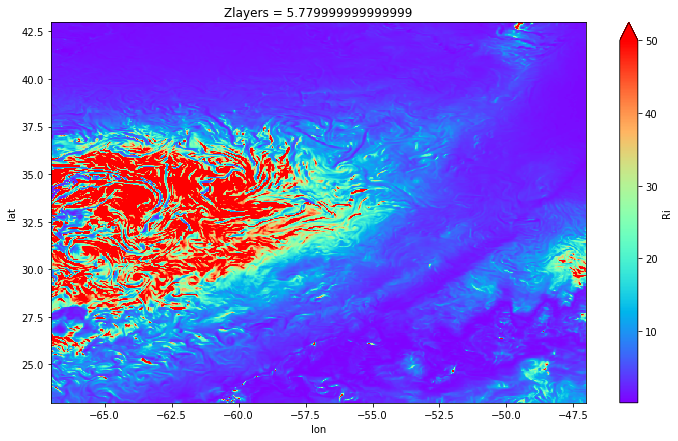

In [63]:
%matplotlib inline
Ri[4].plot(vmin = .1, vmax =50, cmap='rainbow', figsize = (12,7) )

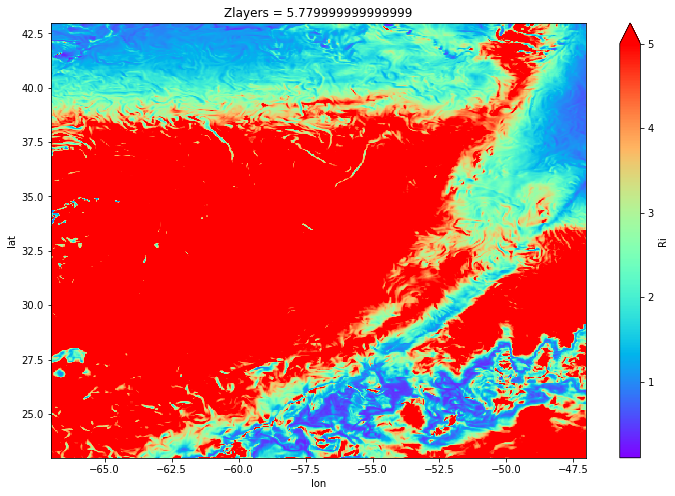

In [60]:
%matplotlib inline
Ri[4].plot(vmin = .1, vmax = 5, cmap='rainbow', figsize= (12,8))

In [69]:
#THIS NEEDS TO BE DOUBLE CHECKED AND YOU NEED TO MAKE THIS WORK WITH XARRAY AND ALL!
InvRi = 1 / Ri
InvRi.name ='Inverse Ri'

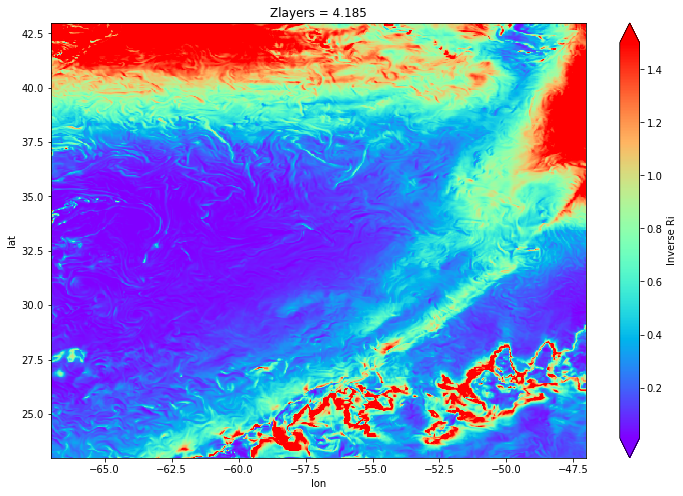

In [85]:
%matplotlib inline
InvRi[3].plot(vmin=0.01, vmax=1.5, cmap = 'rainbow', figsize=(12,8))

Double check that you have good colocation of variables. Xarrayify this so that it can handle time coordiantes 

CCS regions - smaller and maybe easier to handle

In [3]:
thk = scipy.io.loadmat('../Hector_Python_Scripts/thk90')
thickness = thk['thk90'][0,0:90]
depth = thk['dpt90'][0,0:90]
layer_min = 12
layer_max = 18

In [5]:
diag_dir = '/nobackup/amondal/NCData/20220301_diagnostic_vars_for_Ri_layers0_40_CCS/'
SALT = getMITNCDataSet(diag_dir, 'Salt', layer_min, layer_max - 1)
THETA = getMITNCDataSet(diag_dir, 'Theta', layer_min, layer_max - 1)
U = getMITNCDataSet(diag_dir, 'U', layer_min, layer_max - 1)
V = getMITNCDataSet(diag_dir, 'V', layer_min, layer_max - 1)

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has

In [6]:
Ux = U.U
Vx = V.V


In [12]:
D = depth[layer_min+2:layer_max]-depth[layer_min:layer_max-2]
D = D[:,None, None,None]
D = np.tile(D,(1,len(Ux.time),len(Ux.lat),len(Ux.lon)))

In [15]:
Dz = xr.DataArray(D, dims=["Zlayers","time","lat","lon"],  coords = {"Zlayers": depth[layer_min+1:layer_max-1], "time":Ux.time, "lat":Ux.lat, "lon":Ux.lon}, name="Centered Z Derivative of Depths")
Dz

<xarray.DataArray 'Centered Z Derivative of Depths' (Zlayers: 4, time: 313, lat: 75, lon: 75)>
array([[[[10.38 , 10.38 , 10.38 , ..., 10.38 , 10.38 , 10.38 ],
         [10.38 , 10.38 , 10.38 , ..., 10.38 , 10.38 , 10.38 ],
         [10.38 , 10.38 , 10.38 , ..., 10.38 , 10.38 , 10.38 ],
         ...,
         [10.38 , 10.38 , 10.38 , ..., 10.38 , 10.38 , 10.38 ],
         [10.38 , 10.38 , 10.38 , ..., 10.38 , 10.38 , 10.38 ],
         [10.38 , 10.38 , 10.38 , ..., 10.38 , 10.38 , 10.38 ]],

        [[10.38 , 10.38 , 10.38 , ..., 10.38 , 10.38 , 10.38 ],
         [10.38 , 10.38 , 10.38 , ..., 10.38 , 10.38 , 10.38 ],
         [10.38 , 10.38 , 10.38 , ..., 10.38 , 10.38 , 10.38 ],
         ...,
         [10.38 , 10.38 , 10.38 , ..., 10.38 , 10.38 , 10.38 ],
         [10.38 , 10.38 , 10.38 , ..., 10.38 , 10.38 , 10.38 ],
         [10.38 , 10.38 , 10.38 , ..., 10.38 , 10.38 , 10.38 ]],

        [[10.38 , 10.38 , 10.38 , ..., 10.38 , 10.38 , 10.38 ],
         [10.38 , 10.38 , 10.38 , ..., 10.38 , 10.38 , 10.38 ],
         [10.38 , 10.38 , 10.38 , ..., 10.38 , 10.38 , 10.38 ],
         ...,
...
         ...,
         [14.425, 14.425, 14.425, ..., 14.425, 14.425, 14.425],
         [14.425, 14.425, 14.425, ..., 14.425, 14.425, 14.425],
         [14.425, 14.425, 14.425, ..., 14.425, 14.425, 14.425]],

        [[14.425, 14.425, 14.425, ..., 14.425, 14.425, 14.425],
         [14.425, 14.425, 14.425, ..., 14.425, 14.425, 14.425],
         [14.425, 14.425, 14.425, ..., 14.425, 14.425, 14.425],
         ...,
         [14.425, 14.425, 14.425, ..., 14.425, 14.425, 14.425],
         [14.425, 14.425, 14.425, ..., 14.425, 14.425, 14.425],
         [14.425, 14.425, 14.425, ..., 14.425, 14.425, 14.425]],

        [[14.425, 14.425, 14.425, ..., 14.425, 14.425, 14.425],
         [14.425, 14.425, 14.425, ..., 14.425, 14.425, 14.425],
         [14.425, 14.425, 14.425, ..., 14.425, 14.425, 14.425],
         ...,
         [14.425, 14.425, 14.425, ..., 14.425, 14.425, 14.425],
         [14.425, 14.425, 14.425, ..., 14.425, 14.425, 14.425],
         [14.425, 14.425, 14.425, ..., 14.425, 14.425, 14.425]]]])
Coordinates:
  * Zlayers  (Zlayers) float64 34.24 39.72 45.85 52.69
  * time     (time) datetime64[ns] 2020-03-01 2020-03-01T01:00:00 ... 2020-03-14
  * lat      (lat) float64 35.0 35.04 35.08 35.12 ... 37.84 37.88 37.92 37.96
  * lon      (lon) float64 -126.0 -126.0 -125.9 -125.9 ... -123.1 -123.1 -123.0

In [16]:
Ux = Ux.assign_coords(Zlayers = ("Zlayers", depth[layer_min:layer_max]))
Vx = Vx.assign_coords(Zlayers = ("Zlayers", depth[layer_min:layer_max]))

In [17]:
Uxc = Ux.compute()
Vxc = Vx.compute()

In [18]:
Uxp = Uxc.shift(Zlayers=1, fill_value=0)
Uxm = Uxc.shift(Zlayers=-1,fill_value=0)
Vxp = Vxc.shift(Zlayers=1, fill_value=0)
Vxm = Vxc.shift(Zlayers=-1,fill_value=0)

In [19]:
dU = (Uxp-Uxm).sel(Zlayers=Ux.Zlayers[1:-1])
dV = (Vxp-Vxm).sel(Zlayers=Vx.Zlayers[1:-1])
uz_t = dU / Dz
vz_t = dV / Dz
#fixed this!

#### shear = uz_t**2 + vz_t**2
shear.rename(r'$U_z^2 + V_z^2$')

In [4]:
diag_dir = '/nobackup/amondal/NCData/20220301_diagnostic_vars_for_Ri_layers0_40_CCS/'
SALT = getMITNCDataSet(diag_dir, 'Salt', layer_min, layer_max - 1)
THETA = getMITNCDataSet(diag_dir, 'Theta', layer_min, layer_max - 1)

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer


In [60]:
Sc = SALT.Salt.compute()
Tc = THETA.Theta.compute()

In [9]:
depth_range = depth[layer_min:layer_max]
depth_t = depth_range[:,None, None,None]
depth_tile = np.tile(depth_t ,(1,len(Sc.time),len(Sc.lat),len(Sc.lon)))

In [51]:
P = gsw.p_from_z(-1*depth_tile[:,:,0, :], Sc.lat[0].values)
P = np.expand_dims(P, axis = 2)
P.shape

(6, 313, 1, 75)

In [52]:
P2 = gsw.p_from_z(-1*depth_tile[:,:,1, :], Sc.lat[1].values)
P2 = np.expand_dims(P2, axis = 2)
P2.shape

(6, 313, 1, 75)

In [53]:
P = np.concatenate((P, P2), axis = 2)
P.shape

(6, 313, 2, 75)

In [40]:
P3 = gsw.p_from_z(-1*depth_tile[:,:,2, :], Sc.lat[2].values)
P3.shape

(6, 313, 75)

In [41]:
P3 = np.expand_dims(P3, axis = 2)
P = np.concatenate((P,P3), axis = 2)
P3.shape

(6, 313, 1, 75)

In [43]:
P.shape

(6, 313, 4, 75)

In [56]:
# ##compute b at a given layer ##
import gsw
import dens # hector can give you this module if you need it

layer=1
#latitude = 33
b = np.zeros(Sc.values.shape)
ref = 1027.5
P = gsw.p_from_z(-1*depth_tile[:,:,0, :], Sc.lat[0].values)
P = np.expand_dims(P, axis = 2)
for lati in range(1,len(Sc.lat)):
    pressure = gsw.p_from_z(-1*depth_tile[:, :, lati, :], Sc.lat[lati].values)
    pressure = np.expand_dims(pressure, axis = 2)
    P = np.concatenate((P, pressure), axis=2)
#pressure = gsw.p_from_z(-1*depth[layer_min:layer_max],33)


(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313, 1, 75)
(6, 313,

In [59]:
Sc

,Array,Chunk
Bytes,80.60 MiB,43.95 kiB
Shape,"(6, 313, 75, 75)","(1, 1, 75, 75)"
Count,13772 Tasks,1878 Chunks
Type,float64,numpy.ndarray


Oooof, so tiling this the same will will be difficult unless I can switch around dimensions. Zlayers,time, lat, lon

In [64]:
for layers in range(0,layer_max-layer_min):
    rho = dens.densjmd95(Sc[layers,:,:,:], Tc[layers,:,:,:], P[layers,:,:,:])
# rho = dens.densjmd95(s_tot[layer,:,:],t_tot[layer,:,:],depth[layer]) # you can ask Hector the function dens.densjmd95 or use one that you like (e.g., from gsw)
    b[layers] = 9.81*(1-rho/ref)

#here, b is not really defined fully yet. We need a few more derivatives

In [65]:
b.shape

(6, 313, 75, 75)

In [67]:
B = xr.DataArray(b, dims=["Zlayers","time","lat","lon"],  coords = {"Zlayers": depth[layer_min:layer_max], "time":Sc.time, "lat":Sc.lat, "lon":Sc.lon}, name="Buoyancy")

In [ ]:
Bp = B.shift(Zlayers=1, fill_value=0)
Bm = B.shift(Zlayers=-1,fill_value=0)

In [ ]:
dB = (Bp-Bm).sel(Zlayers=B.Zlayers[1:-1])
Bz_t = dB / Dz
Bz_t.rename('dBouyancy / dz')
#fixed this!

In [23]:
#b_z = (b[:-2,:,:]-b[2:,:,:])/D
#bz = b_z[:,1:-1,1:-1] - This is unnecessary because salinity and theta 
#b0 = b0[None,:]
#bz = np.vstack((b0,b_z)) #THIS SETS THE FIRST LAYER'S BUOYANCY GRADIENT TO BE 0 - WHICH DOES MAKE SENSE
Bz_tshift = Bz_t.shift(Zlayers=1, fill_value = 0)
#this should effectively add a layer of zeroes at the top


In [ ]:
Ri = Bz_tshift / shear #test for colocation
Ri.rename('Richardson Number')